# Celda 1: Importación de bibliotecas


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf  # Para calcular la función de error

# Celda 2: Definición de funciones de activación

In [ ]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    den = (1 + np.exp(-z))
    den[den == 0] = 1
    return 1 / den

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Evita overflow
    if z.ndim == 1:  # Si z es un vector unidimensional
        sum_exp_z = np.sum(exp_z)
        sum_exp_z[sum_exp_z == 0] = 1
        return exp_z / sum_exp_z
    else:  # Si z es una matriz bidimensional
        sum_exp_z = np.sum(exp_z, axis=1, keepdims=True)
        # Asegurar que el denominador no sea cero
        sum_exp_z[sum_exp_z == 0] = 1  # Esto evita la división por cero
        return exp_z / sum_exp_z

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def leaky_relu_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def elu(z, alpha=1.0):
    return np.where(z > 0, z, alpha * (np.exp(z) - 1))

def elu_derivative(z, alpha=1.0):
    return np.where(z > 0, 1, alpha * np.exp(z))

def swish(z):
    return z * sigmoid(z)

def swish_derivative(z):
    sig = sigmoid(z)
    return sig + z * sig * (1 - sig)

def gelu(z):
    return 0.5 * z * (1 + erf(z / np.sqrt(2)))

def gelu_derivative(z):
    return 0.5 * (1 + erf(z / np.sqrt(2))) + (z / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)


# Celda 3: Funciones de procesamiento de datos

In [ ]:
def normalizar_caracteristicas(X):
    media = X.mean(axis=0)
    desviacion = X.std(axis=0)
    desviacion[desviacion == 0] = 1
    return (X - media) / desviacion

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
    return loss


# Celda 4: Propagación hacia adelante y hacia atrás

In [ ]:
def forward_propagation(X, W1, b1, W2, b2, activation=sigmoid):
    Z1 = np.dot(X, W1) + b1
    A1 = activation(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return A2, (Z1, A1, Z2, A2)


In [ ]:
def backward_propagation(X, y_true, cache, W1, b1, W2, b2, activation_derivative=sigmoid_derivative, learning_rate=0.01,
                         optimizer='sgd', beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8,
                         v_dW1=None, v_db1=None, v_dW2=None, v_db2=None,
                         s_dW1=None, s_db1=None, s_dW2=None, s_db2=None, t=1):
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]

    # Gradientes para capas
    dZ2 = A2 - y_true
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * activation_derivative(A1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Aplicar el método de optimización seleccionado
    if optimizer == 'momentum':
        v_dW1 = beta * v_dW1 + (1 - beta) * dW1
        v_db1 = beta * v_db1 + (1 - beta) * db1
        v_dW2 = beta * v_dW2 + (1 - beta) * dW2
        v_db2 = beta * v_db2 + (1 - beta) * db2
        W1 -= learning_rate * v_dW1
        b1 -= learning_rate * v_db1
        W2 -= learning_rate * v_dW2
        b2 -= learning_rate * v_db2

    elif optimizer == 'nesterov':
        W1 -= learning_rate * (beta * v_dW1 + (1 - beta) * dW1)
        b1 -= learning_rate * (beta * v_db1 + (1 - beta) * db1)
        W2 -= learning_rate * (beta * v_dW2 + (1 - beta) * dW2)
        b2 -= learning_rate * (beta * v_db2 + (1 - beta) * db2)

    elif optimizer == 'rmsprop':
        s_dW1 = beta * s_dW1 + (1 - beta) * (dW1 ** 2)
        s_db1 = beta * s_db1 + (1 - beta) * (db1 ** 2)
        s_dW2 = beta * s_dW2 + (1 - beta) * (dW2 ** 2)
        s_db2 = beta * s_db2 + (1 - beta) * (db2 ** 2)
        W1 -= learning_rate * dW1 / (np.sqrt(s_dW1) + epsilon)
        b1 -= learning_rate * db1 / (np.sqrt(s_db1) + epsilon)
        W2 -= learning_rate * dW2 / (np.sqrt(s_dW2) + epsilon)
        b2 -= learning_rate * db2 / (np.sqrt(s_db2) + epsilon)

    elif optimizer == 'adam':
        v_dW1 = beta1 * v_dW1 + (1 - beta1) * dW1
        v_db1 = beta1 * v_db1 + (1 - beta1) * db1
        v_dW2 = beta1 * v_dW2 + (1 - beta1) * dW2
        v_db2 = beta1 * v_db2 + (1 - beta1) * db2
        s_dW1 = beta2 * s_dW1 + (1 - beta2) * (dW1 ** 2)
        s_db1 = beta2 * s_db1 + (1 - beta2) * (db1 ** 2)
        s_dW2 = beta2 * s_dW2 + (1 - beta2) * (dW2 ** 2)
        s_db2 = beta2 * s_db2 + (1 - beta2) * (db2 ** 2)

        # Corrección de sesgo para Adam
        v_dW1_corr = v_dW1 / (1 - beta1 ** t)
        v_db1_corr = v_db1 / (1 - beta1 ** t)
        v_dW2_corr = v_dW2 / (1 - beta1 ** t)
        v_db2_corr = v_db2 / (1 - beta1 ** t)
        s_dW1_corr = s_dW1 / (1 - beta2 ** t)
        s_db1_corr = s_db1 / (1 - beta2 ** t)
        s_dW2_corr = s_dW2 / (1 - beta2 ** t)
        s_db2_corr = s_db2 / (1 - beta2 ** t)

        W1 -= learning_rate * v_dW1_corr / (np.sqrt(s_dW1_corr) + epsilon)
        b1 -= learning_rate * v_db1_corr / (np.sqrt(s_db1_corr) + epsilon)
        W2 -= learning_rate * v_dW2_corr / (np.sqrt(s_dW2_corr) + epsilon)
        b2 -= learning_rate * v_db2_corr / (np.sqrt(s_db2_corr) + epsilon)

    else:  # SGD por defecto
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

    return W1, b1, W2, b2, v_dW1, v_db1, v_dW2, v_db2, s_dW1, s_db1, s_dW2, s_db2


# Celda 5: Cargar datos y división de conjuntos

In [ ]:
def load_csv(file_path):
    df = pd.read_csv(file_path)
    label_to_int = {'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}
    df['variety'] = df['variety'].map(label_to_int)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    # Verificar que los tamaños sumen 1
    assert train_size + val_size + test_size == 1, "La suma de los tamaños debe ser 1."

    # Mezclar los índices aleatoriamente
    indices = np.random.permutation(X.shape[0])

    # Calcular los tamaños de cada conjunto
    train_set_size = int(X.shape[0] * train_size)
    val_set_size = int(X.shape[0] * val_size)

    # Asignar los índices a cada conjunto
    train_indices = indices[:train_set_size]
    val_indices = indices[train_set_size:train_set_size + val_set_size]
    test_indices = indices[train_set_size + val_set_size:]

    # Dividir los datos en los conjuntos correspondientes
    return X[train_indices], X[val_indices], X[test_indices], y[train_indices], y[val_indices], y[test_indices]


# Celda 6: Función para graficar pérdida y precisión

In [ ]:
def plot_metrics(loss_history, accuracy_history, test_accuracy_history):
    fig, ax1 = plt.subplots()

    # Plot de pérdida con su propia etiqueta
    color = 'tab:red'
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida', color=color)
    ax1.plot(loss_history, color=color, label='Pérdida')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot de precisión en un eje secundario
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Precisión', color=color)
    ax2.plot(accuracy_history, color=color, label='Precisión Entrenamiento')
    ax2.plot(test_accuracy_history, color='tab:orange', label='Precisión Prueba', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    # Título y leyenda
    plt.title('Pérdida y Precisión durante el Entrenamiento')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid()
    plt.show()


def plot_metrics_validacion(loss_history, val_accuracy_history):
    fig, ax1 = plt.subplots()

    # Plot de pérdida con su propia etiqueta
    color = 'tab:red'
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida', color=color)
    ax1.plot(loss_history, color=color, label='Pérdida')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot de precisión en un eje secundario
    ax2 = ax1.twinx()
    ax2.set_ylabel('Precisión', color=color)
    ax2.plot(val_accuracy_history, color='tab:orange', label='Precisión Validacion')
    ax2.tick_params(axis='y', labelcolor=color)

    # Título y leyenda
    plt.title('Pérdida y Precisión durante el Entrenamiento')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid()
    plt.show()

# Celda 7: Entrenamiento del modelo

In [ ]:
def train_model(X_train, y_train, X_test, y_test, activation=sigmoid, activation_derivative=sigmoid_derivative,
                learning_rate=0.01, epochs=10000, optimizer='sgd', beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
    y_one_hot = one_hot(y_train, 3)
    input_size = X_train.shape[1]
    hidden_size = 100
    output_size = 3

    # Inicialización de pesos y sesgos
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    # Variables adicionales para optimización
    v_dW1, v_db1 = np.zeros_like(W1), np.zeros_like(b1)
    v_dW2, v_db2 = np.zeros_like(W2), np.zeros_like(b2)
    s_dW1, s_db1 = np.zeros_like(W1), np.zeros_like(b1)
    s_dW2, s_db2 = np.zeros_like(W2), np.zeros_like(b2)

    loss_history = []
    accuracy_history = []
    test_accuracy_history = []

    for epoch in range(epochs):
        # Propagación hacia adelante
        y_pred, cache = forward_propagation(X_train, W1, b1, W2, b2, activation)
        loss = compute_loss(y_one_hot, y_pred)
        loss_history.append(loss)

        # Precisión en el conjunto de entrenamiento
        y_pred_labels = np.argmax(y_pred, axis=1)
        accuracy = np.mean(y_pred_labels == y_train)
        accuracy_history.append(accuracy)

        # Precisión en el conjunto de prueba
        y_pred_test = predict(X_test, W1, b1, W2, b2, activation=activation)
        test_accuracy = np.mean(y_pred_test == y_test)
        test_accuracy_history.append(test_accuracy)

        #if epoch % 1000 == 0:
        #    print(f"Época {epoch}, Pérdida: {loss:.4f}, Precisión Entrenamiento: {accuracy * 100:.2f}%, Precisión Prueba: {test_accuracy * 100:.2f}%")

        # Retropropagación con el optimizador seleccionado
        W1, b1, W2, b2, v_dW1, v_db1, v_dW2, v_db2, s_dW1, s_db1, s_dW2, s_db2 = backward_propagation(
            X_train, y_one_hot, cache, W1, b1, W2, b2, activation_derivative=activation_derivative, learning_rate=learning_rate,
            optimizer=optimizer, beta=beta, beta1=beta1, beta2=beta2, epsilon=epsilon,
            v_dW1=v_dW1, v_db1=v_db1, v_dW2=v_dW2, v_db2=v_db2, s_dW1=s_dW1, s_db1=s_db1, s_dW2=s_dW2, s_db2=s_db2
        )

    return W1, b1, W2, b2, loss_history, accuracy_history, test_accuracy_history

def validacion(X_train, y_train, X_test, y_test, X_val, y_val, activation=sigmoid, activation_derivative=sigmoid_derivative,
                learning_rate=0.01, epochs=10000, optimizer='sgd', beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, hidden_size=100):
    y_one_hot = one_hot(y_train, 3)
    input_size = X_train.shape[1]
    output_size = 3

    # Inicialización de pesos y sesgos
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    # Variables adicionales para optimización
    v_dW1, v_db1 = np.zeros_like(W1), np.zeros_like(b1)
    v_dW2, v_db2 = np.zeros_like(W2), np.zeros_like(b2)
    s_dW1, s_db1 = np.zeros_like(W1), np.zeros_like(b1)
    s_dW2, s_db2 = np.zeros_like(W2), np.zeros_like(b2)

    loss_history = []
    accuracy_history = []
    test_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        # Propagación hacia adelante
        y_pred, cache = forward_propagation(X_train, W1, b1, W2, b2, activation)

        # Precisión en el conjunto de prueba
        y_pred_val = predict(X_val, W1, b1, W2, b2, activation=activation)
        val_accuracy = np.mean(y_pred_val == y_val)
        val_accuracy_history.append(val_accuracy)

        #if epoch % 1000 == 0:
        #    print(f"Época {epoch}, Pérdida: {loss:.4f}, Precisión Entrenamiento: {accuracy * 100:.2f}%, Precisión Prueba: {test_accuracy * 100:.2f}%")

        # Retropropagación con el optimizador seleccionado
        W1, b1, W2, b2, v_dW1, v_db1, v_dW2, v_db2, s_dW1, s_db1, s_dW2, s_db2 = backward_propagation(
            X_train, y_one_hot, cache, W1, b1, W2, b2, activation_derivative=activation_derivative, learning_rate=learning_rate,
            optimizer=optimizer, beta=beta, beta1=beta1, beta2=beta2, epsilon=epsilon,
            v_dW1=v_dW1, v_db1=v_db1, v_dW2=v_dW2, v_db2=v_db2, s_dW1=s_dW1, s_db1=s_db1, s_dW2=s_dW2, s_db2=s_db2
        )

    return W1, b1, W2, b2, loss_history, val_accuracy_history



# Celda 8: Evaluación del modelo

In [ ]:
def predict(X, W1, b1, W2, b2, activation=sigmoid):
    y_pred, _ = forward_propagation(X, W1, b1, W2, b2, activation=activation)
    return np.argmax(y_pred, axis=1)


# Celda 9: Cargar datos y preparar conjuntos de entrenamiento y prueba

In [ ]:
import requests
import zipfile
import io
import os

# URL del archivo zip
url = "https://gist.github.com/netj/8836201/archive/6f9306ad21398ea43cba4f7d537619d0e07d5ae3.zip"

# Descargar el archivo zip
response = requests.get(url)
response.raise_for_status()  # Verifica si la solicitud fue exitosa

# Extraer solo el archivo dentro del zip, sin la carpeta
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    for file_info in zip_ref.infolist():
        if not file_info.is_dir():  # Verifica que sea un archivo
            # Renombra el archivo para que no incluya la carpeta
            file_name = os.path.basename(file_info.filename)
            with zip_ref.open(file_info) as source, open(file_name, "wb") as target:
                target.write(source.read())

print("Archivo descargado y guardado correctamente.")

Archivo descargado y guardado correctamente.


In [ ]:
X, y = load_csv("iris.csv")
X = normalizar_caracteristicas(X)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

# Celda 10: Validacion de hiperparametros

In [ ]:
activations = {
    "Sigmoid": (sigmoid, sigmoid_derivative),
    "ReLU": (relu, relu_derivative),
    "Leaky ReLU": (leaky_relu, leaky_relu_derivative),
    "Tanh": (tanh, tanh_derivative),
    "Swish": (swish, swish_derivative),
    "GELU": (gelu, gelu_derivative)
}

for name, (activation, derivative) in activations.items():
    for lr in [0.5, 0.2, 0.1, 0.01]:
        for neurons in [100, 50, 30, 10]:
            W1, b1, W2, b2, loss_history, val_accuracy_history = validacion(
                X_train, y_train, X_test, y_test, X_val, y_val,
                activation=activation,
                activation_derivative=derivative,
                optimizer='nesterov',    # Cambia a 'momentum', 'nesterov', 'rmsprop', 'adam' o 'sgd' según el optimizador deseado
                learning_rate=lr,    # Cambia la tasa de aprendizaje aquí
                epochs=5000,            # Cambia el número de épocas aquí
                hidden_size=neurons   #cambia el numero de neuronas en la capa oulta aqui
            )


            #plot_metrics_validacion(loss_history, val_accuracy_history)

            # Precisión final
            final_val_accuracy = val_accuracy_history[-1] * 100
            print(f"Precisión final en prueba ({name}) con lr = {lr} y numero de neuronas en la capa oculta = {neurons}: {final_val_accuracy:.2f}%\n")

Precisión final en prueba (Sigmoid) con lr = 0.5 y numero de neuronas en la capa oculta = 100: 90.91%

Precisión final en prueba (Sigmoid) con lr = 0.5 y numero de neuronas en la capa oculta = 50: 90.91%

Precisión final en prueba (Sigmoid) con lr = 0.5 y numero de neuronas en la capa oculta = 30: 90.91%

Precisión final en prueba (Sigmoid) con lr = 0.5 y numero de neuronas en la capa oculta = 10: 81.82%

Precisión final en prueba (Sigmoid) con lr = 0.2 y numero de neuronas en la capa oculta = 100: 90.91%

Precisión final en prueba (Sigmoid) con lr = 0.2 y numero de neuronas en la capa oculta = 50: 90.91%

Precisión final en prueba (Sigmoid) con lr = 0.2 y numero de neuronas en la capa oculta = 30: 95.45%

Precisión final en prueba (Sigmoid) con lr = 0.2 y numero de neuronas en la capa oculta = 10: 86.36%

Precisión final en prueba (Sigmoid) con lr = 0.1 y numero de neuronas en la capa oculta = 100: 90.91%

Precisión final en prueba (Sigmoid) con lr = 0.1 y numero de neuronas en la cap

# Celda 11: Entrenamiento y evaluación con diferentes activaciones

Entrenando con Sigmoid...


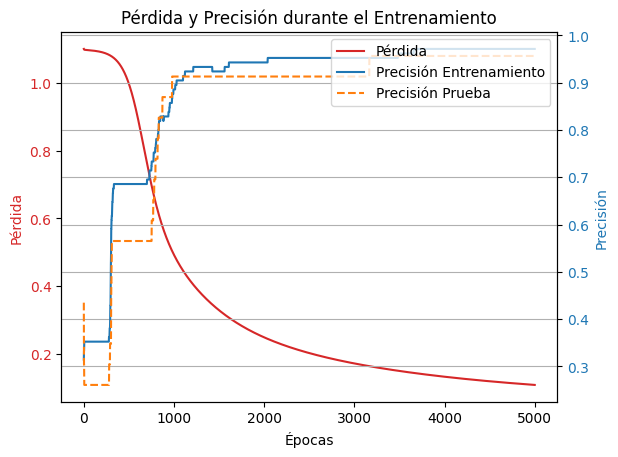

Precisión final en entrenamiento (Sigmoid): 97.14%
Precisión final en prueba (Sigmoid): 95.65%

Entrenando con ReLU...


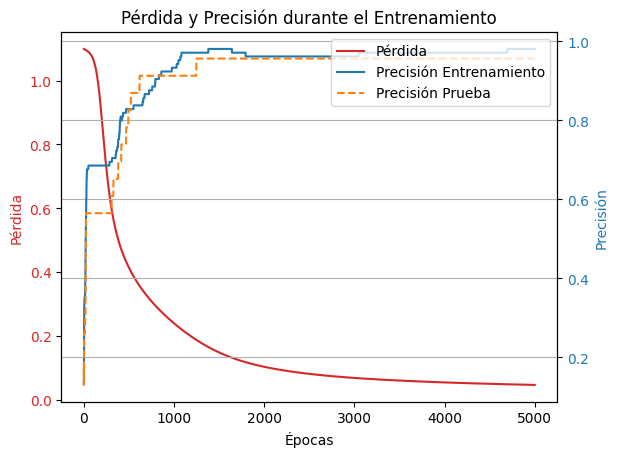

Precisión final en entrenamiento (ReLU): 98.10%
Precisión final en prueba (ReLU): 95.65%

Entrenando con Leaky ReLU...


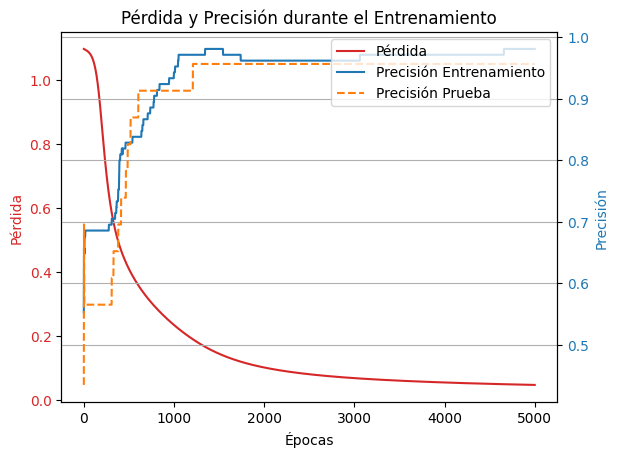

Precisión final en entrenamiento (Leaky ReLU): 98.10%
Precisión final en prueba (Leaky ReLU): 95.65%

Entrenando con Tanh...


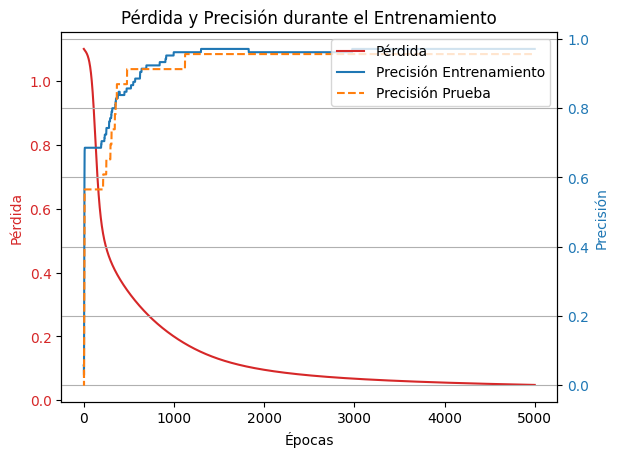

Precisión final en entrenamiento (Tanh): 97.14%
Precisión final en prueba (Tanh): 95.65%

Entrenando con Swish...


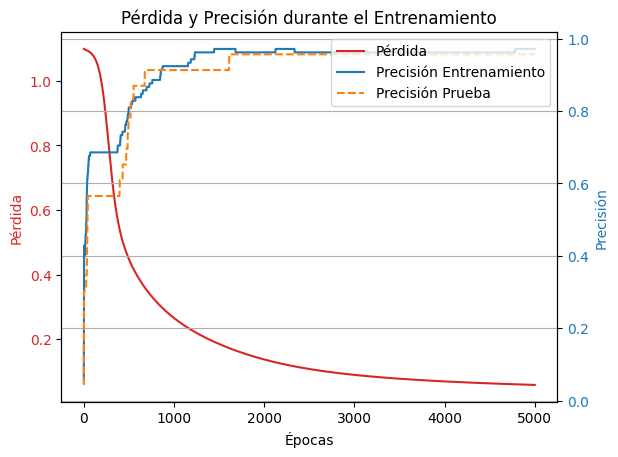

Precisión final en entrenamiento (Swish): 97.14%
Precisión final en prueba (Swish): 95.65%

Entrenando con GELU...


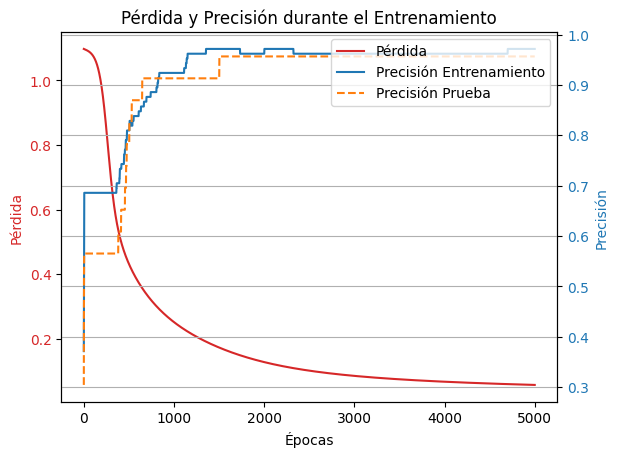

Precisión final en entrenamiento (GELU): 97.14%
Precisión final en prueba (GELU): 95.65%



In [19]:
activations = {
    "Sigmoid": (sigmoid, sigmoid_derivative),
    "ReLU": (relu, relu_derivative),
    "Leaky ReLU": (leaky_relu, leaky_relu_derivative),
    "Tanh": (tanh, tanh_derivative),
    "Swish": (swish, swish_derivative),
    "GELU": (gelu, gelu_derivative)
}

for name, (activation, derivative) in activations.items():
    print(f"Entrenando con {name}...")
    W1, b1, W2, b2, loss_history, accuracy_history, test_accuracy_history = train_model(
        X_train, y_train, X_test, y_test,
        activation=activation,
        activation_derivative=derivative,
        optimizer='nesterov',     # Cambia a 'momentum', 'nesterov', 'rmsprop', 'adam' o 'sgd' según el optimizador deseado
        learning_rate=0.2,        # Cambia la tasa de aprendizaje aquí
        epochs=5000               # Cambia el número de épocas aquí
    )


    plot_metrics(loss_history, accuracy_history, test_accuracy_history)

    # Precisión final
    final_train_accuracy = accuracy_history[-1] * 100
    final_test_accuracy = test_accuracy_history[-1] * 100
    print(f"Precisión final en entrenamiento ({name}): {final_train_accuracy:.2f}%")
    print(f"Precisión final en prueba ({name}): {final_test_accuracy:.2f}%\n")
